# Test Technique Data Scientist

**Auteur**: Eric Chen

**Data :**


The aim of the project is to write a functional and structured code in python using a jupyter notebook.

The code should be able to make a prediction on the dataset Auto Insurance based on the Kaggle competition:

https://www.kaggle.com/c/auto-insurance-fall-2017

The data can be found in this repository

The target for this project is TARGET_FLAG

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier, plot_importance
import seaborn as sns
from matplotlib import pyplot

#!pip install category_encoders
#import category_encoders as ce

## Dataset Exploration

**In this part, we explore the dataset, looking at the columns, their types and whether they have missing values**

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Read the csv file representing the dataset to build the model
df = pd.read_csv('/content/train_auto.csv', index_col=0)
df.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [4]:
# List of columns with the type and the non-null count
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   object 
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   object 
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   object 
 19  OLDCL

**In the following cell, we are looking at the correlation between the target variable and the numerical features. We will look later at the correlation for the rest of the features (for instance, categorical features).**

We observe that "TARGET_AMT" seems to have the highest correlation value with "TARGET_FLAG". This is something we would need to consider when building the model later.

In [5]:
# Get the correlation between some columns
df.corr()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE
TARGET_FLAG,1.000000,0.534246,0.103668,-0.103217,0.115621,-0.070512,0.048368,-0.082370,0.216196,0.219197,-0.100651
TARGET_AMT,0.534246,1.000000,0.055394,-0.041728,0.061988,-0.022085,0.027987,-0.046481,0.116419,0.137866,-0.058822
KIDSDRIV,0.103668,0.055394,1.000000,-0.075179,0.464015,0.043305,0.008447,-0.001989,0.037063,0.053566,-0.053993
AGE,-0.103217,-0.041728,-0.075179,1.000000,-0.445441,0.136072,0.005269,-0.000066,-0.024092,-0.071575,0.176221
HOMEKIDS,0.115621,0.061988,0.464015,-0.445441,1.000000,0.086829,-0.007246,0.011813,0.029349,0.060601,-0.152146
YOJ,-0.070512,-0.022085,0.043305,0.136072,0.086829,1.000000,-0.016945,0.024787,-0.026308,-0.037855,0.061406
TRAVTIME,0.048368,0.027987,0.008447,0.005269,-0.007246,-0.016945,1.000000,-0.011605,0.006560,0.010599,-0.038233
TIF,-0.082370,-0.046481,-0.001989,-0.000066,0.011813,0.024787,-0.011605,1.000000,-0.023023,-0.041046,0.007767
CLM_FREQ,0.216196,0.116419,0.037063,-0.024092,0.029349,-0.026308,0.006560,-0.023023,1.000000,0.396638,-0.009319
MVR_PTS,0.219197,0.137866,0.053566,-0.071575,0.060601,-0.037855,0.010599,-0.041046,0.396638,1.000000,-0.019904


Here, we look at the distribution of "TARGET_FLAG" values. We only have 2 values: 0 and 1, therefore this is a **binary classification problem**. We observe that the **dataset is really unbalanced**, so we can adopt different strategies to consider this issue (use of specific metrics, penalized models, oversampling, etc.)

Text(0.5, 1.0, 'Target variable distribution')

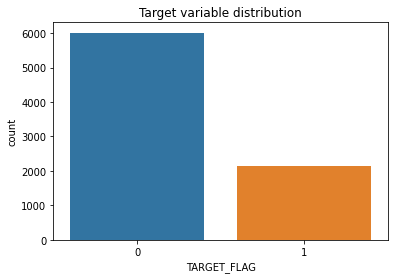

In [6]:
# Get the histogram of the distribution of the classes in the target variable
sns.countplot("TARGET_FLAG", data=df).set_title('Target variable distribution')

## Data Pre-Processing

Overall, we can see that we have we have columns with different types. We have numerical columns and categorical columns. Categorical features generally have the object type. We need to perform some specific transformations to use categorical features in the modelling phase.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   object 
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   object 
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   object 
 19  OLDCL

For some features related to price, we have some symbols such as "," or "$". These characters prevent us from consider the related columns as numerical features. In the following cell, we remove these symbols and convert the columns into numerical features.

In [8]:
# Convert the columns that have the type "object" with numerical values into numerical features
cols_num = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]

df[cols_num] = df[cols_num].replace("[$,]", "", regex=True).astype(float).astype('Int64')


In this part, we look at the number of disctinct elements we have for each categorical feature. There are no more than 8 distincts elements per feature so that we can use ordinal encoding or one-hot encoding depending on the situation.


In [9]:
# Get the list of columns representing categorical variables
cols_obj = df.columns[df.dtypes == 'object']
for col in cols_obj:
    print(str(col) + ': ' + str(df[col].nunique()) + ' distinct elements')

PARENT1: 2 distinct elements
MSTATUS: 2 distinct elements
SEX: 2 distinct elements
EDUCATION: 5 distinct elements
JOB: 8 distinct elements
CAR_USE: 2 distinct elements
CAR_TYPE: 6 distinct elements
RED_CAR: 2 distinct elements
REVOKED: 2 distinct elements
URBANICITY: 2 distinct elements


We perform ordinal encoding when we can order the different values of a categorical feature. In our case, "EDUCATION" can be ordered by assigning the highest value to the highest degree and so on.

For categorical values, only "JOB" has missing values so we can create another value "MISSING" for this column to replace the missing values.

In [10]:
# Perform Ordinal Encoding on the "EDUCATION" column (because there is an order)
df["EDUCATION"] = df["EDUCATION"].replace({'PhD': 4, 'Masters': 3, 'Bachelors': 2, 'z_High School': 1, '<High School': 0})

# For categorical features, only "JOB" has missing values, we can create another category for missing values
df["JOB"] = df["JOB"].fillna("Missing")

For the rest of the categorical features, there is no specific ordering of their values so we can use one-hot encoding. This is consistent because we do not have a large number of distinct elements for each categorical features

In [11]:
# Perform one-hot encoding on the rest of columns representing categorical variables
df_one_hot = pd.get_dummies(df, columns=cols_obj[cols_obj!='EDUCATION'])

After the pre-processing step, we can look at the correlation matrix between the features. "TARGET_AMT" seems to have the highest value in terms of absolute value of the correlation with "TARGET_FLAG". It would be interesting to drop this feature in the modelling part to see its effect.

In [12]:
# Perform correlation computation
df_one_hot.corr()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,EDUCATION,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE,PARENT1_No,PARENT1_Yes,MSTATUS_Yes,MSTATUS_z_No,SEX_M,SEX_z_F,JOB_Clerical,JOB_Doctor,JOB_Home Maker,JOB_Lawyer,JOB_Manager,JOB_Missing,JOB_Professional,JOB_Student,JOB_z_Blue Collar,CAR_USE_Commercial,CAR_USE_Private,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV,RED_CAR_no,RED_CAR_yes,REVOKED_No,REVOKED_Yes,URBANICITY_Highly Urban/ Urban,URBANICITY_z_Highly Rural/ Rural
TARGET_FLAG,1.000000,0.534246,0.103668,-0.103217,0.115621,-0.070512,-0.142008,-0.183737,-0.131351,0.048368,-0.103383,-0.082370,0.138084,0.216196,0.219197,-0.100651,-0.157622,0.157622,-0.135125,0.135125,-0.021079,0.021079,0.027367,-0.058377,0.011259,-0.061731,-0.105395,-0.003133,-0.038572,0.077014,0.101787,0.142674,-0.142674,-0.136999,-0.000342,0.056643,0.057253,0.003020,0.045032,0.006947,-0.006947,-0.151939,0.151939,0.224251,-0.224251
TARGET_AMT,0.534246,1.000000,0.055394,-0.041728,0.061988,-0.022085,-0.058307,-0.085602,-0.056470,0.027987,-0.004700,-0.046481,0.070953,0.116419,0.137866,-0.058822,-0.096965,0.096965,-0.087661,0.087661,0.011054,-0.011054,0.007805,-0.034750,-0.007082,-0.029186,-0.064606,0.015671,-0.004547,0.024410,0.061830,0.098614,-0.098614,-0.075267,0.029468,0.021907,0.023294,0.023479,0.005943,-0.008092,0.008092,-0.061385,0.061385,0.120974,-0.120974
KIDSDRIV,0.103668,0.055394,1.000000,-0.075179,0.464015,0.043305,-0.047134,-0.019792,-0.071489,0.008447,-0.021549,-0.001989,0.020403,0.037063,0.053566,-0.053993,-0.196604,0.196604,0.042461,-0.042461,-0.045934,0.045934,0.036062,-0.039342,0.003875,-0.037810,-0.011019,-0.031195,-0.022353,0.025643,0.037842,0.001422,-0.001422,-0.014106,-0.010112,-0.000382,-0.001638,-0.025950,0.038153,0.043638,-0.043638,-0.043062,0.043062,-0.037124,0.037124
AGE,-0.103217,-0.041728,-0.075179,1.000000,-0.445441,0.136072,0.180970,0.209984,0.244326,0.005269,0.165025,-0.000066,-0.029290,-0.024092,-0.071575,0.176221,0.314025,-0.314025,0.090716,-0.090716,0.066052,-0.066052,-0.149065,0.116972,0.001480,0.135831,0.089306,0.053368,0.035976,-0.124727,-0.064808,-0.033304,0.033304,0.011029,0.051590,-0.034588,0.022480,0.020723,-0.042542,-0.020324,0.020324,0.038477,-0.038477,0.051351,-0.051351
HOMEKIDS,0.115621,0.061988,0.464015,-0.445441,1.000000,0.086829,-0.159330,-0.110680,-0.203696,-0.007246,-0.107894,0.011813,0.029911,0.029349,0.060601,-0.152146,-0.449274,0.449274,0.043526,-0.043526,-0.111511,0.111511,0.124213,-0.079240,0.017010,-0.098243,-0.071874,-0.069455,-0.058324,0.128167,0.043402,-0.004458,0.004458,-0.039664,-0.059960,-0.002861,0.035917,-0.043670,0.080946,0.068148,-0.068148,-0.045116,0.045116,-0.063483,0.063483
YOJ,-0.070512,-0.022085,0.043305,0.136072,0.086829,1.000000,0.286074,0.269920,0.087403,-0.016945,0.143465,0.024787,-0.002980,-0.026308,-0.037855,0.061406,0.049767,-0.049767,0.145631,-0.145631,0.084826,-0.084826,0.103999,0.034402,-0.339095,0.073145,0.076488,0.051085,0.081987,-0.323364,0.122079,0.022337,-0.022337,0.053529,0.044584,0.001254,-0.065647,0.041465,-0.061513,-0.050633,0.050633,0.006415,-0.006415,0.083870,-0.083870
INCOME,-0.142008,-0.058307,-0.047134,0.180970,-0.159330,0.286074,1.000000,0.575244,0.604210,-0.047082,0.429280,-0.001035,-0.045442,-0.047752,-0.063159,0.414238,0.075257,-0.075257,-0.030724,0.030724,0.107779,-0.107779,-0.252681,0.250451,-0.303590,0.188668,0.199913,0.315838,0.123076,-0.357098,-0.033201,0.081031,-0.081031,0.038190,0.226373,-0.063381,-0.098728,0.129205,-0.137205,-0.058807,0.058807,0.020737,-0.020737,0.206004,-0.206004
HOME_VAL,-0.183737,-0.085602,-0.019792,0.209984,-0.110680,0.269920,0.575244,1.000000,0.345363,-0.035525,0.259533,0.002063,-0.069195,-0.094049,-0.085395,0.217468,0.261065,-0.261065,0.459408,-0.459408,0.071360,-0.071360,-0.124171,0.116105,-0.153560,0.119213,0.127894,0.160065,0.110636,-0.332754,0.012354,0.027353,-0.027353,0.025553,0.127767,-0.038159,-0.053745,0.079644,-0.084649,-0.016212,0.016212,

Here, we can split the dataset into training and testing sets (with a ratio of 0.2)

In [13]:
# Create a matrix of features X and the target variable y
y = df_one_hot['TARGET_FLAG']
X = df_one_hot.drop(columns='TARGET_FLAG')

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we can fill in the missing values for each column.

* for numerical features, we replace missing values with the mean
* for categorical features, we already replaced missing values in a previous cell

In [14]:
# Get the list of columns with missing values
cols_miss_val = []
for col in X_train.columns:
    if X_train[col].isna().sum() != 0:
        cols_miss_val.append(col)

In [15]:
cols_miss_val

['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'CAR_AGE']

In [16]:
X_train[cols_miss_val] = X_train[cols_miss_val].astype("float")
X_test[cols_miss_val] = X_test[cols_miss_val].astype("float")

# Fill in the missing values in X_train and y_train with the mean
for col in cols_miss_val:
    mean_val = X_train[col].mean()
    X_train[col].fillna(mean_val, inplace=True)
    X_test[col].fillna(mean_val, inplace=True)

## Analysis and Model training

In this part, we scale the numerical features and remove the "TARGET_AMT".

In [17]:
# Get column names that were not in the original dataframe (created with one-hot encoding)
list_cat = list(df_one_hot.columns[~df_one_hot.columns.isin(df.columns)])
list_cat.append("EDUCATION")

In [18]:
# Select only the columns that do not represent categorical variables (only the numerical variables)
continuous_cols = X_train.columns[~X_train.columns.isin(list_cat)]

# Scale the numerical features (for Logistic Regression)
scaler = StandardScaler()
X_scaled_train = X_train.copy()
X_scaled_test = X_test.copy()
X_scaled_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_scaled_test[continuous_cols] = scaler.transform(X_test[continuous_cols]) 

In [19]:
# Remove "TARGET_AMT" 
X_scaled_train.drop(columns='TARGET_AMT', inplace=True)
X_scaled_test.drop(columns='TARGET_AMT', inplace=True)

We experiment with 3 models that can be used in a classification problem:
* Logistic Regression
* Random Forest
* XGBoost

We observed that the dataset was unbalanced, so in terms of performance metrics, we can use Recall, Precision or F1 Score. We use the test set to compute these metrics. Because F1 Score can be considered as a harmonic mean of Recall and Precision, let's use it as the main performance metric. We also print the confusion matrix to have more detailed results.

### Logistic Regression

In [20]:
# Train and test the Logistic Regression model with the default parameters
logreg = LogisticRegression()
logreg.fit(X_scaled_train, y_train)
y_pred_logreg = logreg.predict(X_scaled_test)

In [21]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred_logreg))

[[1109   80]
 [ 261  183]]


In [22]:
# Print the classification report
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1189
           1       0.70      0.41      0.52       444

    accuracy                           0.79      1633
   macro avg       0.75      0.67      0.69      1633
weighted avg       0.78      0.79      0.77      1633



In [23]:
# Hyperparameter Tuning with Grid Search CV for Logistic Regression
tuned_parameters = {"C": [100, 10, 1.0, 0.1, 0.01],
                    "penalty": ['l1', 'l2', 'elasticnet']}
clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring="f1")
clf.fit(X_scaled_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Detailed classification report:")
print()
y_true, y_pred = y_test, clf.predict(X_scaled_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 10, 'penalty': 'l2'}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1189
           1       0.70      0.41      0.52       444

    accuracy                           0.79      1633
   macro avg       0.75      0.67      0.69      1633
weighted avg       0.78      0.79      0.77      1633




### RandomForestClassifier

In [24]:
# Train and test the RandomForest model with the default parameters 
rf = RandomForestClassifier()
rf.fit(X_scaled_train, y_train)
y_pred_rf = rf.predict(X_scaled_test)

In [25]:
# Print the confusion matrix 
confusion_matrix(y_test, y_pred_rf)

array([[1116,   73],
       [ 274,  170]])

In [26]:
# Print the classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1189
           1       0.70      0.38      0.49       444

    accuracy                           0.79      1633
   macro avg       0.75      0.66      0.68      1633
weighted avg       0.77      0.79      0.76      1633



In [27]:
# Hyperparameter Tuning with Grid Search CV for Random Forest
tuned_parameters = {'max_depth': [5, 10, None],
                    'min_samples_leaf': [1, 2],
                    'min_samples_split': [2, 5],
                    'n_estimators': [100, 200]}
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, scoring="f1")
clf.fit(X_scaled_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Detailed classification report:")
print()
y_true, y_pred = y_test, clf.predict(X_scaled_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1189
           1       0.71      0.40      0.51       444

    accuracy                           0.79      1633
   macro avg       0.76      0.67      0.69      1633
weighted avg       0.78      0.79      0.77      1633




### XGBoost

In [28]:
# Train and test the XGBoost model with the default parameters
xgb = XGBClassifier()
xgb.fit(X_scaled_train, y_train) 
y_pred_xgb = xgb.predict(X_scaled_test)

In [29]:
# Print the confusion matrix
confusion_matrix(y_test, y_pred_xgb)

array([[1115,   74],
       [ 256,  188]])

In [30]:
# Print the classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1189
           1       0.72      0.42      0.53       444

    accuracy                           0.80      1633
   macro avg       0.77      0.68      0.70      1633
weighted avg       0.79      0.80      0.78      1633



In [35]:
# Hyperparameter Tuning with Grid Search CV for XGBoost
tuned_parameters = {"learning_rate" : [0.01, 0.05, 0.10],
                    "max_depth" : [1, 6, 10],
                    "min_child_weight" : [1, 3, 10],
                    #"gamma": [ 0.0, 0.7, 0.9],
}
clf = GridSearchCV(XGBClassifier(), tuned_parameters, scoring="f1")
clf.fit(X_scaled_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Detailed classification report:")
print()
y_true, y_pred = y_test, clf.predict(X_scaled_test)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 3}

Detailed classification report:

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1189
           1       0.66      0.44      0.53       444

    accuracy                           0.79      1633
   macro avg       0.73      0.68      0.69      1633
weighted avg       0.77      0.79      0.77      1633




After training our 3 models, we can observe that the results are quite similar if we consider the macro F1 Score (around 0.69-0.7). XGBoost gives us the best results for the macro F1 Score and for Class 1.

## Final Predictions

**We will retrain the best model, which is the XGBClassifier with the hyperparameters chosen thanks to GridSearchCV, using the entire dataset.**

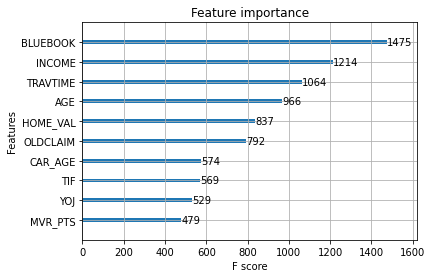

In [46]:
# Get the list of columns with missing values
cols_miss_val = []
for col in X.columns:
    if X[col].isna().sum() != 0:
        cols_miss_val.append(col)

X[cols_miss_val] = X[cols_miss_val].astype("float")
# Fill in the missing values in X with the mean (X the matrix of features)
for col in cols_miss_val:
    mean_val = X[col].mean()
    X[col].fillna(mean_val, inplace=True)

# Drop the "TARGET_AMT" column for the entire dataset
X.drop(columns='TARGET_AMT', inplace=True)

# Convert the following columns into float
X[['BLUEBOOK', 'OLDCLAIM']] = X[['BLUEBOOK', 'OLDCLAIM']].astype("float")

# Train the XGBoost model with the best hyperparameters and plot the features importance
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=3)
xgb.fit(X, y)
plot_importance(xgb, max_num_features=10)

In [45]:
plot_importance?

**Then, we apply the same pre-processing for the dataset called "test_auto" for which we want to predict the labels**

In [47]:
# Read the csv file for which we want the predictions
df = pd.read_csv('/content/test_auto.csv', index_col=0)

# Convert the columns that have the type "object" with numerical values into numerical features
cols_num = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
df[cols_num] = df[cols_num].replace("[$,]", "", regex=True).astype(float).astype('Int64')

# Get the list of columns representing categorical variables
cols_obj = df.columns[df.dtypes == 'object']

# Perform Ordinal Encoding on the "EDUCATION" column (because there is an order)
df["EDUCATION"] = df["EDUCATION"].replace({'PhD': 4, 'Masters': 3, 'Bachelors': 2, 'z_High School': 1, '<High School': 0})

# For categorical features, only "JOB" has missing values, we can create another category for missing values
df["JOB"] = df["JOB"].fillna("Missing")

# Perform one-hot encoding on the rest of columns representing categorical variables
df_one_hot = pd.get_dummies(df, columns=cols_obj[cols_obj!='EDUCATION'])

# Drop the "TARGET_AMT" and "TARGET_FLAG" columns for the entire dataset
df_one_hot.drop(columns=['TARGET_FLAG','TARGET_AMT'], inplace=True)

# Get the list of columns with missing values
cols_miss_val = []
for col in df_one_hot.columns:
    if df_one_hot[col].isna().sum() != 0:
        cols_miss_val.append(col)

df_one_hot[cols_miss_val] = df_one_hot[cols_miss_val].astype("float")
# Fill in the missing values in df_one_hot with the mean 
for col in cols_miss_val:
    mean_val = df_one_hot[col].mean()
    df_one_hot[col].fillna(mean_val, inplace=True)

df_one_hot[['BLUEBOOK', 'OLDCLAIM']] = df_one_hot[['BLUEBOOK', 'OLDCLAIM']].astype("float")

In [48]:
# Write the final predictions in a csv file
y_pred_final = xgb.predict(df_one_hot)

result = df.copy()
result["TARGET_FLAG"] = y_pred_final
result.to_csv("test_predictions.csv")

In [59]:
result

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,
3,0,NaN,0,48.0,0,11.0,52881,No,0,z_No,M,2,Manager,26,Private,21970,1,Van,yes,0,0,No,2,10.0,Highly Urban/ Urban
9,0,NaN,1,40.0,1,11.0,50815,Yes,0,z_No,M,1,Manager,21,Private,18930,6,Minivan,no,3295,1,No,2,1.0,Highly Urban/ Urban
10,0,NaN,0,44.0,2,12.0,43486,Yes,0,z_No,z_F,1,z_Blue Collar,30,Commercial,5900,10,z_SUV,no,0,0,No,0,10.0,z_Highly Rural/ Rural
18,0,NaN,0,35.0,2,NaN,21204,Yes,0,z_No,M,1,Clerical,74,Private,9230,6,Pickup,no,0,0,Yes,0,4.0,z_Highly Rural/ Rural
21,0,NaN,0,59.0,0,12.0,87460,No,0,z_No,M,1,Manager,45,Private,15420,1,Minivan,yes,44857,2,No,4,1.0,Highly Urban/ Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10279,1,NaN,0,46.0,0,0.0,0,No,0,Yes,z_F,1,Student,32,Commercial,1500,6,Sports Car,no,20519,1,Yes,3,8.0,z_Highly Rural/ Rural
10281,0,NaN,0,46.0,0,12.0,43501,No,134977,Yes,M,1,Professional,60,Private,16080,3,Minivan,no,0,0,No,2,1.0,z_Highly Rural/ Rural
10285,0,NaN,0,55.0,0,10.0,141083,No,393624,Yes,z_F,3,Lawyer,42,Private,21110,10,Sports Car,no,0,0,No,0,22.0,z_Highly Rural/ Rural
